In [2]:
! pip install -V lifelines==0.27.0
! pip install -v pandas==1.2.0
! pip install -v matplotlib==2.2.3
! pip install pgl

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.1/349.1 kB 4.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 3.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.2/68.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 3.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.9/930.9 kB 2.0 MB/s eta 0:00:0000:0100:01
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4034 sha256=c7eeef3cee8026b1d7f38e8bc980175f171391e5808d6407a52bb8f9919f47fd
  Stored in directory: /home/aistudio/.cache/pip/wheels/ab/0b/5c/977e05dfabbeeb83fc49bdb43b17fbdf47a3dfc2913a4d4a27
Successfully built autograd-gamma
  Attempting uninstall: pandas
    Found existing installatio

In [10]:
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
import pgl

import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

import scipy.sparse as sparse
from sklearn import cluster
from sklearn.preprocessing import normalize
from sklearn.utils import check_random_state, check_symmetric
from sklearn.neighbors import kneighbors_graph

from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import multivariate_logrank_test

import os
import re

import warnings 
warnings.filterwarnings("ignore")
class MLP(nn.Layer):
    def __init__(self, in_dim, out_dim, hid_dim):
        # hid_dim should be a list
        super(MLP, self).__init__()
        self.layers = nn.LayerList()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        # 1st layer
        self.layers.append(nn.Linear(self.in_dim, self.hid_dim[0], weight_attr=nn.initializer.KaimingUniform()))
        self.layers.append(nn.ReLU())
        # hidden layer
        for i in range(len(self.hid_dim) - 1):
            self.layers.append(nn.Linear(self.hid_dim[i], self.hid_dim[i+1], weight_attr=nn.initializer.KaimingUniform()))
            self.layers.append(nn.ReLU())
        # last layer
        self.out_layer = nn.Linear(self.hid_dim[-1], out_dim, weight_attr=nn.initializer.KaimingUniform())
    
    def forward(self, x):
        h = x
        for i, layer in enumerate(self.layers):
            h = layer(h)
        h = self.out_layer(h)
        h = paddle.tanh_(h)
        return h

class AdoptiveSoftThreshold(nn.Layer):
    def __init__(self, dim):
        super(AdoptiveSoftThreshold, self).__init__()
        self.dim = dim
        self.add_parameter("bias", paddle.create_parameter(shape=[self.dim], dtype="float32", attr=nn.initializer.Constant(value=0.0)))
    
    def forward(self, c):
        return paddle.sign(c) * F.relu(paddle.abs(c) - self.bias)


class SENet(nn.Layer):
    def __init__(self, in_dim, out_dim, hid_dim):
        super(SENet, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        # layers
        self.query_net = MLP(in_dim=self.in_dim, out_dim=self.out_dim, hid_dim=self.hid_dim)
        self.key_net = MLP(in_dim=self.in_dim, out_dim=self.out_dim, hid_dim=self.hid_dim)
        self.threshold = AdoptiveSoftThreshold(1)
        # hyparameters
        self.shrink = 1.0 / out_dim

    def query_embedding(self, query):
        query_emb = self.query_net(query)
        return query_emb
    
    def key_embedding(self, key):
        key_emb = self.key_net(key)
        return key_emb

    def get_coef(self, query, keys):
        c = self.threshold(paddle.mm(query, keys.T))
        return self.shrink * c

    def forward(self, x, others):
        query = self.query_embedding(x)
        key = self.key_embedding(others)
        out = self.get_coef(query, key)
        return out

def make_graph(array, k=20):
    feature = paddle.to_tensor(array, dtype="float32")
    _, idx = paddle.topk(feature, k)
    idx = idx.numpy()
    edges = list()
    for i in range(idx.shape[0]):
        for j in idx[i]:
            edges.append((i, j))
    g = pgl.Graph(edges = edges,
                num_nodes = feature.shape[0],
                node_feat = {'nfeat':feature.T})
    return g.tensor(), feature

def regularizer(c, lmbd=1.0):
    return lmbd * paddle.sum(paddle.abs(c)) + (1.0 - lmbd) / 2.0 * paddle.sum(paddle.pow(c, 2))

def p_normalize(x, p=2):
    return x / (paddle.norm(x, p=p, axis=1, keepdim=True) + 1e-6)

def get_knn_Aff(C_sparse_normalized, k=3, mode='symmetric'):
    C_knn = kneighbors_graph(C_sparse_normalized, k, mode='connectivity', include_self=False, n_jobs=10)
    if mode == 'symmetric':
        Aff_knn = 0.5 * (C_knn + C_knn.T)
    elif mode == 'reciprocal':
        Aff_knn = C_knn.multiply(C_knn.T)
    else:
        raise Exception("Mode must be 'symmetric' or 'reciprocal'")
    return Aff_knn

def spectral_clustering(affinity_matrix_, n_clusters, k, seed=1, n_init=20):
    affinity_matrix_ = check_symmetric(affinity_matrix_)
    random_state = check_random_state(seed)

    laplacian = sparse.csgraph.laplacian(affinity_matrix_, normed=True)
    _, vec = sparse.linalg.eigsh(sparse.identity(laplacian.shape[0]) - laplacian, 
                                 k=k, sigma=None, which='LA')
    embedding = normalize(vec)
    _, labels_, _ = cluster.k_means(embedding, n_clusters, 
                                         random_state=seed, n_init=n_init)
    return labels_

def get_sparse_rep(model, data, batch_size=10, chunk_size=100, non_zeros = 10000):
    N, D = data.shape
    non_zeros = min(N, non_zeros)
    c = paddle.empty([batch_size, N])
    if (N % batch_size != 0):
        raise Exception("batch_size should be a factor of dataset size.")
    if (N % chunk_size != 0):
        raise Exception("chunk_size should be a factor of dataset size.")

    val = list()
    indicies = list()

    with paddle.no_grad():
        model.eval()
        for i in range(data.shape[0] // batch_size):
            chunk = data[i * batch_size:(i + 1) * batch_size].cuda()
            q = model.query_embedding(chunk)                                                                                                                                                                 
            for j in range(data.shape[0] // chunk_size):
                chunk_samples = data[j * chunk_size: (j + 1) * chunk_size].cuda()
                k = model.key_embedding(chunk_samples)   
                coef = model.get_coef(q, k)
                c[:, j * chunk_size:(j + 1) * chunk_size] = coef.cpu()
            
            # diag c reset to zero
            rows = list(range(batch_size))
            cols = [j + i * batch_size for j in rows]
            c[rows, cols] = 0.0
            tmp = paddle.zeros_like(c)
            # sort
            _, index = paddle.topk(paddle.abs(c), axis=1, k=non_zeros)
            for line in range(index.shape[0]):
                tmp[line] = c[line].gather(index[line])
            # val.append(paddle.gather(c, index=index, axis=1).reshape([-1]).cpu().numpy())
            val.append(tmp.reshape([-1]).cpu().numpy())
            index = index.reshape([-1]).cpu().numpy()
            indicies.append(index)

    val = np.concatenate(val, axis=0)
    indicies = np.concatenate(indicies, axis=0)
    indptr = [non_zeros * i for i in range(N + 1)]
    
    C_sparse = sparse.csr_matrix((val, indicies, indptr), shape=[N, N])
    return C_sparse
    
def lifeline_analysis(df, n_groups):
    kmf = KaplanMeierFitter()
    plt.figure()
    for group in range(n_groups):
        idx = (df["label"] == group)
        kmf.fit(df['Survival'][idx], df['Death'][idx], label = group)
        ax = kmf.plot()
        treatment_median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

def evaluate(senet, data, num_subspaces, spectral_dim, non_zeros=1000, n_neighbors=3,
             batch_size=10000, chunk_size=10000, affinity='nearest_neighbor', knn_mode='symmetric'):
    C_sparse = get_sparse_rep(model=senet, data=data, batch_size=batch_size,
                              chunk_size=chunk_size, non_zeros=non_zeros)
    C_sparse_normalized = normalize(C_sparse).astype(np.float32)
    # plt.matshow(np.sort(np.abs(C_sparse_normalized.toarray())))
    if affinity == 'symmetric':
        Aff = 0.5 * (np.abs(C_sparse_normalized) + np.abs(C_sparse_normalized).T)
    elif affinity == 'nearest_neighbor':
        Aff = get_knn_Aff(C_sparse_normalized, k=n_neighbors, mode=knn_mode)
    else:
        raise Exception("affinity should be 'symmetric' or 'nearest_neighbor'")
    
    preds = spectral_clustering(Aff, num_subspaces, spectral_dim)

    return C_sparse_normalized, preds

def load_data(path):
    path = os.path.join("TCGA", path)
    exp = pd.read_csv(os.path.join(path, "exp"), sep = " ")
    methy = pd.read_csv(os.path.join(path, "methy"), sep = " ")
    mirna = pd.read_csv(os.path.join(path, "mirna"), sep = " ")
    survival = pd.read_csv(os.path.join(path, "survival"), sep = "\t")
    survival = survival.dropna(axis=0)
    if len(survival["PatientID"][0]) > len('tcga.16.1060'):
        name_list = list()
        survival["PatientID"] = [re.sub("-", ".", x) for x in survival["PatientID"].str.upper()]
        for token in survival["PatientID"]:
            if token[-2] != "0":
                survival.drop(survival[survival["PatientID"] == token].index, inplace = True)
                continue
            name_list.append(token)
            if token not in exp:
                exp[token] = exp.mean(axis=1)
            if token not in methy:
                methy[token] = methy.mean(axis=1)
            if token not in mirna:
                mirna[token] = mirna.mean(axis=1)
    else:
        survival["PatientID"] = [re.sub("-", ".", x) for x in survival["PatientID"].str.upper() + ".01"]
        for token in survival["PatientID"]:
            if token not in exp:
                exp[token] = exp.mean(axis=1)
            if token not in methy:
                methy[token] = methy.mean(axis=1)
            if token not in mirna:
                mirna[token] = mirna.mean(axis=1)
        name_list = survival["PatientID"]
    exp = exp[name_list]
    methy = methy[name_list]
    mirna = mirna[name_list]

    return [exp, methy, mirna, survival]

def draw_coef(coefficient, pred, N, epoch):
    pc = pd.DataFrame(np.abs(coefficient.toarray()))
    pc = pc + pc.T
    pc["label"] = pred
    pc = pc.sort_values("label")
    idx = pc.index
    pc = pc[idx]
    plt.pcolor(pc)
    plt.savefig(os.path.join("/home/aistudio/.jupyter/lab/workspaces/figures", str(N), str(epoch), ".png"))
    # plt.show()

class GCN(nn.Layer):
    """Implement of GCN
    """

    def __init__(self,
                 input_size,
                 num_class,
                 num_layers=3,
                 hidden_size=256,
                 **kwargs):
        super(GCN, self).__init__()
        self.num_class = num_class
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gcns = nn.LayerList()
        for i in range(self.num_layers):
            if i == 0:
                self.gcns.append(
                    pgl.nn.GCNConv(
                        input_size,
                        self.hidden_size,
                        activation="relu",
                        norm=True))
            else:
                self.gcns.append(
                    pgl.nn.GCNConv(
                        self.hidden_size,
                        self.hidden_size,
                        activation="relu",
                        norm=True))
        self.output = nn.Linear(self.hidden_size, self.num_class, weight_attr=nn.initializer.KaimingUniform())
    def forward(self, graph, feature):
        for m in self.gcns:
            feature = m(graph, feature)
        logits = self.output(feature)
        return logits

class Attention(nn.Layer):
    def __init__(self, in_size, hidden_size=16):
        super(Attention, self).__init__()
        self.project = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, z):
        w = self.project(z)
        beta = paddle.nn.functional.softmax(w, axis=1)
        return (beta * z).sum(1), beta

class SEGN(nn.Layer):
    def __init__(self, in_dim, out_dim, hid_dim):
        super(SEGN, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        # layers
        self.special_emb_exp = GCN(input_size=self.in_dim, num_class=self.out_dim, hidden_size=self.hid_dim)
        self.special_emb_methy = GCN(input_size=self.in_dim, num_class=self.out_dim, hidden_size=self.hid_dim)
        self.special_emb_mirna = GCN(input_size=self.in_dim, num_class=self.out_dim, hidden_size=self.hid_dim)

        self.common_emb = GCN(input_size=self.in_dim, num_class=self.out_dim, hidden_size=self.hid_dim)
        self.threshold = AdoptiveSoftThreshold(1)

        self.attention = Attention(out_dim, hidden_size=hid_dim)
        # hyparameters
        self.shrink = 1.0 / out_dim

    def special_embedding(self, graphs, features):
        emb_1 = self.special_emb_exp(graphs[0], features[0])
        emb_2 = self.special_emb_methy(graphs[1], features[1])
        emb_3 = self.special_emb_mirna(graphs[2], features[2])

        return paddle.stack([emb_1, emb_2, emb_3], axis=1)
    
    def shared_embedding(self, graphs, features):
        shared_emb = self.common_emb(graphs, features)
        return shared_emb

    def get_coef(self, query, keys):
        c = self.threshold(paddle.mm(query, keys.T))
        return self.shrink * c

    def forward(self, graphs, features):
        shared_1 = self.shared_embedding(graphs[0], features[0])
        shared_2 = self.shared_embedding(graphs[1], features[1])
        shared_3 = self.shared_embedding(graphs[2], features[2])
        shared = (shared_1 + shared_2 + shared_3) / 3

        special = self.special_embedding(graphs, features)
        emb, att = self.attention(special)
        out = self.get_coef(shared, emb)
        return out, shared, emb, att

def make_graph(array, k=20):
    feature = paddle.to_tensor(array, dtype="float32")
    _, idx = paddle.topk(feature, k)
    idx = idx.numpy()
    edges = list()
    for i in range(idx.shape[0]):
        for j in idx[i]:
            edges.append((i, j))
    g = pgl.Graph(edges = edges,
                num_nodes = feature.shape[0],
                node_feat = {'nfeat':feature.T})
    return g.tensor(), feature

def g_evaluate(model, graphs, features, num_subspaces, spectral_dim, non_zeros=1000, n_neighbors=3,
             batch_size=10000, chunk_size=10000, affinity='nearest_neighbor', knn_mode='symmetric'):
    N, D = features[0].shape
    non_zeros = min(N, non_zeros)
    c = paddle.empty([batch_size, N])
    val = list()
    indicies = list()

    with paddle.no_grad():
        model.eval()
        coef, shared, emb, att = g_ae(graphs, features)
        c = coef.cpu()

        rows = list(range(batch_size))
        cols = [j for j in rows]
        c[rows, cols] = 0.0
        tmp = paddle.zeros_like(c)
        # sort
        _, index = paddle.topk(paddle.abs(c), axis=1, k=batch_size)
        for line in range(index.shape[0]):
            tmp[line] = c[line].gather(index[line])
        # val.append(paddle.gather(c, index=index, axis=1).reshape([-1]).cpu().numpy())
        val.append(tmp.reshape([-1]).cpu().numpy())
        index = index.reshape([-1]).cpu().numpy()
        indicies.append(index)
    val = np.concatenate(val, axis=0)
    indicies = np.concatenate(indicies, axis=0)
    indptr = [non_zeros * i for i in range(N + 1)]
    C_sparse = sparse.csr_matrix((val, indicies, indptr), shape=[N, N])
    
    C_sparse_normalized = normalize(C_sparse).astype(np.float32)
    # plt.matshow(np.sort(np.abs(C_sparse_normalized.toarray())))
    if affinity == 'symmetric':
        Aff = 0.5 * (np.abs(C_sparse_normalized) + np.abs(C_sparse_normalized).T)
    elif affinity == 'nearest_neighbor':
        Aff = get_knn_Aff(C_sparse_normalized, k=n_neighbors, mode=knn_mode)
    else:
        raise Exception("affinity should be 'symmetric' or 'nearest_neighbor'")
    
    preds = spectral_clustering(Aff, num_subspaces, spectral_dim)

    return C_sparse_normalized, preds



In [4]:
from tqdm import tqdm

cancer_type = "coad"
[exp, methy, mirna, survival] = load_data(cancer_type)

conf = dict()
conf["dataset"] = cancer_type
conf["chunk_size"] = exp.shape[1]

conf["batch_size"] = 100
conf["out_dim"] = 512
conf["hid_dim"] = [1024, 1024]

conf["learning_rate"] = 1e-3
conf["lmbd"] = 0.1
conf["gamma"] = 50
conf["min_lr"] = 1e-4
conf["total_iters"] = 20000
conf["save_iter"] = 2000
conf["eval_iter"] = 500
if conf["dataset"] == "bic":
    conf["subspace"] = 5
elif conf["dataset"] == "coad":
    conf["subspace"] = 4
elif conf["dataset"] is "gbm":
    conf["subspace"] = 3
elif conf["dataset"] is "kirc":
    conf["subspace"] = 4
elif conf["dataset"] is "ov":
    conf["subspace"] = 3
elif conf["dataset"] is "lusc":
    conf["subspace"] = 5
elif conf["dataset"] is "skcm":
    conf["subspace"] = 5
else:
    pass
conf["spectral_dim"] = 15
conf["non_zeros"] = 10000
conf["n_neighbors"] = 3
conf["affinity"] = "nearest_neighbor"
conf["g_lmbd"] = 0.5
conf["g_gamma"] = 10
conf["g_learning_rate"] = 0.0001

In [6]:
def train_process(data, conf, which):
    row_data = paddle.to_tensor(data.to_numpy(), dtype="float32")
    # row_data shape [20531, 1229]
    global_step = 0

    folder = "{}_result".format(conf["dataset"])
    if not os.path.exists(folder):
        os.mkdir(folder)
    result = open(f'{folder}/{which}_results.csv', 'w+')
    writer = csv.writer(result)
    writer.writerow(["-log(p)", "p", "iters"])
    for N in [200]:
        block_size = min(N, 600)
        sample_idx = np.random.choice(row_data.shape[1], N, replace=False)
        data = row_data.T[sample_idx]
        data = p_normalize(data)
        sample_shape = data.shape
        n_iter_per_epoch = data.shape[0] // conf["batch_size"]
        # data.shape [sampel, dim]
        n_step_per_iter = round(data.shape[0] // block_size)
        n_epochs = conf["total_iters"] // n_iter_per_epoch
        
        local_senet = SENet(sample_shape[1], conf["out_dim"], conf["hid_dim"])

        # para_dict = paddle.load("local_net.pdparams")
        # local_senet.load_dict(para_dict)
        
        clip = paddle.nn.ClipGradByGlobalNorm(clip_norm=0.001)
        opt = paddle.optimizer.AdamW(learning_rate=conf["learning_rate"], parameters=local_senet.parameters(), grad_clip=clip)
        scheduler = paddle.optimizer.lr.CosineAnnealingDecay(conf["learning_rate"], T_max=n_epochs, eta_min=conf["min_lr"])

        n_iter = 0
        pbar = tqdm(range(n_epochs), ncols=120)
        for epoch in pbar:
            pbar.set_description(f"Epoch {epoch}")
            randidx = paddle.randperm(sample_shape[0])
            for i in range(n_iter_per_epoch):
                # each batch in sample
                local_senet.train()
                batch_idx = randidx[i * conf["batch_size"] : (i + 1) * conf["batch_size"]]
                batch = data[batch_idx]
                # process all embedding of query and key
                query_batch = local_senet.query_embedding(batch)
                key_batch = local_senet.query_embedding(batch)

                rec_batch = paddle.zeros_like(batch)
                reg = paddle.zeros([1])
                # each batch be reconstructed by sample
                for j in range(n_step_per_iter):
                    block = data[j * block_size: (j + 1) * block_size]
                    key_block = local_senet.key_embedding(block)
                    coef = local_senet.get_coef(query_batch, key_block)
                    rec_batch = rec_batch + paddle.mm(coef, block)
                    reg = reg + regularizer(coef, conf["lmbd"])
            
                diag_c = local_senet.threshold((query_batch * key_batch).sum(axis=1, keepdim=True)) * local_senet.shrink
                rec_batch = rec_batch - diag_c * batch
                rec_loss = paddle.sum(paddle.pow(batch - rec_batch, 2))
                loss = (0.5 * conf["gamma"] * rec_loss + reg) / conf["batch_size"]

                opt.clear_grad()
                loss.backward()
                opt.step()

                global_step += 1
                n_iter += 1

                if n_iter % conf["save_iter"] == 0:
                    paddle.save(local_senet.state_dict(), f"{folder}/{which}/{which}_{n_iter}_local.pdparams")
                    paddle.save(opt.state_dict(), "opt.pdopt")
                    # print("Save Success.")
                
                if n_iter % conf["eval_iter"] == 0:
                    # print("Evaluating on {}-full...".format(conf["dataset"]))
                    full_data = p_normalize(row_data)
                    coefficient, pred = evaluate(local_senet, data=full_data.T, num_subspaces=conf["subspace"], affinity=conf["affinity"],
                                            spectral_dim=conf["spectral_dim"], non_zeros=conf["non_zeros"], n_neighbors=conf["n_neighbors"], batch_size=conf["chunk_size"],
                                            chunk_size=conf["chunk_size"], knn_mode='symmetric')
                    survival["label"] = pred
                    df = survival
                    # lifeline_analysis(df, conf["subspace"])
                    results = multivariate_logrank_test(df['Survival'], df['label'], df['Death'])
                    if results.summary["p"].item() < 7e-7:
                        paddle.save(local_senet.state_dict(), f"{folder}/{which}/{which}_{n_iter}_local.pdparams")
                    # print("-log2(p)-{:.6f}, p-{:.6f}".format(results.summary["-log2(p)"].item(), results.summary["p"].item()))
                    writer.writerow([results.summary["-log2(p)"].item(), results.summary["p"].item(), n_iter])
                    # writer.writerow([results.summary["-log2(p)"].item(), results.summary["p"].item(), coefficient.toarray(), pred])
                    result.flush()

            pbar.set_postfix(loss="{:3.4f}".format(loss.item()),
                                rec_loss="{:3.4f}".format(rec_loss.item() / conf["batch_size"]),
                                reg="{:3.4f}".format(reg.item() / conf["batch_size"]))
            scheduler.step()
    
    return local_senet

In [ ]:
# start local train
exp_net = train_process(exp, conf, "exp")
methy_net = train_process(methy, conf, "methy")
mirna_net = train_process(mirna, conf, "mirna")


W0611 16:39:03.784927 38822 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W0611 16:39:03.788691 38822 device_context.cc:465] device: 0, cuDNN Version: 7.6.
Epoch 1580:  16%|███▊                    | 1576/10000 [00:32<02:40, 52.52it/s, loss=3.1334, rec_loss=0.1133, reg=0.3017]

In [23]:
# feature vis graph by pca
from sklearn.manifold import TSNE
from sklearn.datasets import load_iris,load_digits
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os

def draw_coef(coefficient, pred, who, iters):
    pc = pd.DataFrame(np.abs(coefficient.toarray()))
    pc = pc + pc.T
    pc["label"] = pred
    pc = pc.sort_values("label")
    idx = pc.index
    pc = pc[idx]
    plt.pcolor(pc)
    plt.savefig(f"figures/{who}/{iters}")
    # plt.show()

def draw_coef_resutl(model, data, who):
    for i in range(2000, 22000, 2000):
        path = f"bic_result/{who}/{who}_{str(i)}_local.pdparams"
        para_dict = paddle.load(path)
        model.load_dict(para_dict)
        c1, pred1 = evaluate(model, data=p_normalize(paddle.to_tensor(data.to_numpy().T, dtype="float32")), num_subspaces=conf["subspace"], affinity=conf["affinity"],
                                        spectral_dim=conf["spectral_dim"], non_zeros=conf["non_zeros"], n_neighbors=conf["n_neighbors"], batch_size=conf["chunk_size"],
                                        chunk_size=conf["chunk_size"], knn_mode='symmetric')
        draw_coef(c1, pred1, str(who), str(i))
        
def lifeline_analysis(df, n_groups, title_g="bic"):
    kmf = KaplanMeierFitter()
    plt.figure()
    for group in range(n_groups):
        idx = (df["label"] == group)
        kmf.fit(df['Survival'][idx], df['Death'][idx], label = group)
        plt.xlabel("lifeline(days)")
        plt.ylabel("survival probability")
        ax = kmf.plot()
        plt.title(title_g)
        treatment_median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
# draw_coef_resutl(mirna_net, mirna, "mirna")

In [17]:
para_dict = paddle.load("coad_result/global/global_4000_local.pdparams")
g_ae.load_dict(para_dict)
coef, shared, emb, att = g_ae([g1, g2, g3], [f1, f2,f3])
coefficient, pred = g_evaluate(g_ae, [g1, g2, g3], [f1, f2,f3], num_subspaces=conf["subspace"], affinity=conf["affinity"],
                                        spectral_dim=conf["spectral_dim"], non_zeros=conf["non_zeros"], n_neighbors=conf["n_neighbors"], batch_size=conf["chunk_size"],
                                        chunk_size=conf["chunk_size"], knn_mode='symmetric')


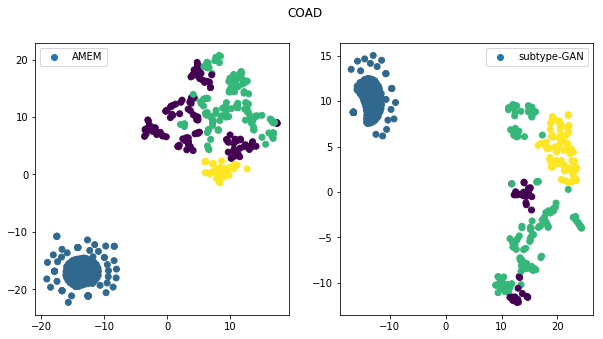

In [25]:
draw_distr(coefficient, pred, gan, pred_gan, "COAD")

In [16]:
exp_net = SENet(exp.shape[0], conf["out_dim"], conf["hid_dim"])
methy_net = SENet(methy.shape[0], conf["out_dim"], conf["hid_dim"])
mirna_net = SENet(mirna.shape[0], conf["out_dim"], conf["hid_dim"])
if conf["dataset"] is "bic":
    para_dict = paddle.load("bic_result/exp/exp_3000_local.pdparams") 
    exp_net.load_dict(para_dict)
    para_dict = paddle.load("bic_result/methy/methy_14000_local.pdparams") 
    methy_net.load_dict(para_dict)
    para_dict = paddle.load("bic_result/mirna/mirna_16000_local.pdparams")
    mirna_net.load_dict(para_dict)
elif conf["dataset"] is "coad":
    para_dict = paddle.load("coad_result/exp/exp_20000_local.pdparams") 
    exp_net.load_dict(para_dict)
    para_dict = paddle.load("coad_result/methy/methy_16000_local.pdparams") 
    methy_net.load_dict(para_dict)
    para_dict = paddle.load("coad_result/mirna/mirna_16000_local.pdparams")
    mirna_net.load_dict(para_dict)
elif conf["dataset"] is "gbm":
    para_dict = paddle.load("gbm_result/exp/exp_20000_local.pdparams") 
    exp_net.load_dict(para_dict)
    para_dict = paddle.load("gbm_result/methy/methy_20000_local.pdparams") 
    methy_net.load_dict(para_dict)
    para_dict = paddle.load("gbm_result/mirna/mirna_18000_local.pdparams")
    mirna_net.load_dict(para_dict)
elif conf["dataset"] is "kirc":
    para_dict = paddle.load("kirc_result/exp/exp_7500_local.pdparams") 
    exp_net.load_dict(para_dict)
    para_dict = paddle.load("kirc_result/methy/methy_14000_local.pdparams") 
    methy_net.load_dict(para_dict)
    para_dict = paddle.load("kirc_result/mirna/mirna_16000_local.pdparams")
    mirna_net.load_dict(para_dict)
elif conf["dataset"] is "lusc":
    para_dict = paddle.load("lusc_result/exp/exp_20000_local.pdparams") 
    exp_net.load_dict(para_dict)
    para_dict = paddle.load("lusc_result/methy/methy_20000_local.pdparams") 
    methy_net.load_dict(para_dict)
    para_dict = paddle.load("lusc_result/mirna/mirna_20000_local.pdparams")
    mirna_net.load_dict(para_dict)
elif conf["dataset"] is "skcm":
    para_dict = paddle.load("lusc_result/exp/exp_4000_local.pdparams") 
    exp_net.load_dict(para_dict)
    para_dict = paddle.load("lusc_result/methy/methy_14000_local.pdparams") 
    methy_net.load_dict(para_dict)
    para_dict = paddle.load("lusc_result/mirna/mirna_16000_local.pdparams")
    mirna_net.load_dict(para_dict)
c1, pred1 = evaluate(exp_net, data=p_normalize(paddle.to_tensor(exp.to_numpy().T, dtype="float32")), num_subspaces=conf["subspace"], affinity=conf["affinity"],
                                        spectral_dim=conf["spectral_dim"], non_zeros=conf["non_zeros"], n_neighbors=conf["n_neighbors"], batch_size=conf["chunk_size"],
                                        chunk_size=conf["chunk_size"], knn_mode='symmetric')
c2, pred2 = evaluate(methy_net, data=p_normalize(paddle.to_tensor(methy.to_numpy().T, dtype="float32")), num_subspaces=conf["subspace"], affinity=conf["affinity"],
                                        spectral_dim=conf["spectral_dim"], non_zeros=conf["non_zeros"], n_neighbors=conf["n_neighbors"], batch_size=conf["chunk_size"],
                                        chunk_size=conf["chunk_size"], knn_mode='symmetric')
c3, pred3 = evaluate(mirna_net, data=p_normalize(paddle.to_tensor(mirna.to_numpy().T, dtype="float32")), num_subspaces=conf["subspace"], affinity=conf["affinity"],
                                        spectral_dim=conf["spectral_dim"], non_zeros=conf["non_zeros"], n_neighbors=conf["n_neighbors"], batch_size=conf["chunk_size"],
                                        chunk_size=conf["chunk_size"], knn_mode='symmetric')
if conf["dataset"] is "bic":
    # 4000
    g1, f1 = make_graph(c1.toarray(), 12)
    g2, f2 = make_graph(c2.toarray(), 12)
    g3, f3 = make_graph(c3.toarray(), 12)
elif conf["dataset"] is "coad":
    # 12000
    g1, f1 = make_graph(c1.toarray(), 4)
    g2, f2 = make_graph(c2.toarray(), 4)
    g3, f3 = make_graph(c3.toarray(), 4)
elif conf["dataset"] is "gbm":
    # 12000
    g1, f1 = make_graph(c1.toarray(), 5)
    g2, f2 = make_graph(c2.toarray(), 5)
    g3, f3 = make_graph(c3.toarray(), 5)
elif conf["dataset"] is "kirc":
    # 12000
    g1, f1 = make_graph(c1.toarray(), 6)
    g2, f2 = make_graph(c2.toarray(), 6)
    g3, f3 = make_graph(c3.toarray(), 6)
elif conf["dataset"] is "lusc":
    g1, f1 = make_graph(c1.toarray(), 6)
    g2, f2 = make_graph(c2.toarray(), 5)
    g3, f3 = make_graph(c3.toarray(), 5)
elif conf["dataset"] is "kirc":
    g1, f1 = make_graph(c1.toarray(), 5)
    g2, f2 = make_graph(c2.toarray(), 5)
    g3, f3 = make_graph(c3.toarray(), 5)
f1 = p_normalize(f1)
f2 = p_normalize(f2)
f3 = p_normalize(f3)
g_dim = [f1.shape[0], f1.shape[0], 512]
g_ae = SEGN(g_dim[0], g_dim[1], g_dim[2])

In [ ]:
conf["g_lmbd"] = 0.3
conf["g_gamma"] = 100
conf["g_learning_rate"] = 1e-3

folder = "{}_result".format(conf["dataset"])
if not os.path.exists(folder):
    os.mkdir(folder)
result = open(f'{folder}/graph_results.csv', 'w+')
writer = csv.writer(result)
writer.writerow(["-log(p)", "p", "iters"])


# get graph and normalized
if conf["dataset"] is "bic":
    # 4000
    g1, f1 = make_graph(c1.toarray(), 12)
    g2, f2 = make_graph(c2.toarray(), 12)
    g3, f3 = make_graph(c3.toarray(), 12)
elif conf["dataset"] is "coad":
    # 12000
    g1, f1 = make_graph(c1.toarray(), 4)
    g2, f2 = make_graph(c2.toarray(), 4)
    g3, f3 = make_graph(c3.toarray(), 4)
elif conf["dataset"] is "gbm":
    # 12000
    g1, f1 = make_graph(c1.toarray(), 5)
    g2, f2 = make_graph(c2.toarray(), 5)
    g3, f3 = make_graph(c3.toarray(), 5)
elif conf["dataset"] is "kirc":
    # 12000
    g1, f1 = make_graph(c1.toarray(), 6)
    g2, f2 = make_graph(c2.toarray(), 6)
    g3, f3 = make_graph(c3.toarray(), 6)
elif conf["dataset"] is "lusc":
    g1, f1 = make_graph(c1.toarray(), 6)
    g2, f2 = make_graph(c2.toarray(), 5)
    g3, f3 = make_graph(c3.toarray(), 5)
elif conf["dataset"] is "kirc":
    g1, f1 = make_graph(c1.toarray(), 5)
    g2, f2 = make_graph(c2.toarray(), 5)
    g3, f3 = make_graph(c3.toarray(), 5)
f1 = p_normalize(f1)
f2 = p_normalize(f2)
f3 = p_normalize(f3)
g_dim = [f1.shape[0], f1.shape[0], 512]
g_ae = SEGN(g_dim[0], g_dim[1], g_dim[2])


clip = paddle.nn.ClipGradByGlobalNorm(clip_norm=0.001)
g_opt = paddle.optimizer.AdamW(learning_rate=conf["g_learning_rate"], parameters=g_ae.parameters(), grad_clip=clip)
pbar = tqdm(range(80000), ncols=120)

n_iter = 0

for epoch in pbar:
    g_ae.train()
    coef, shared, emb, att = g_ae([g1, g2, g3], [f1, f2,f3])
    diag_c = g_ae.threshold((shared * emb).sum(axis=1, keepdim=True)) * g_ae.shrink
    rec_g1 = paddle.mm(coef, f1) - diag_c * f1
    rec_g2 = paddle.mm(coef, f2) - diag_c * f2
    rec_g3 = paddle.mm(coef, f3) - diag_c * f3

    reg = regularizer(coef, conf["g_lmbd"])

    g_loss1 = (0.5 * conf["g_gamma"] * paddle.sum(paddle.pow(rec_g1 - f1, 2)) + reg) / f1.shape[0]
    g_loss2 = (0.5 * conf["g_gamma"] * paddle.sum(paddle.pow(rec_g2 - f2, 2)) + reg) / f1.shape[0]
    g_loss3 = (0.5 * conf["g_gamma"] * paddle.sum(paddle.pow(rec_g3 - f3, 2)) + reg) / f1.shape[0]

    rec_loss = paddle.sum(paddle.pow(rec_g1 - f1, 2)) + paddle.sum(paddle.pow(rec_g2 - f2, 2)) + paddle.sum(paddle.pow(rec_g3 - f3, 2))
    # loss = g_loss1 + g_loss2 + g_loss3
    loss = (0.5 * conf["g_gamma"] * rec_loss + reg) / f1.shape[0]

    consis_loss = 0.1 * paddle.sum(paddle.pow(paddle.matmul(shared.T, shared) - paddle.matmul(emb.T, emb) ,2)) / f1.shape[0]
    loss += consis_loss 
    # print(consis_loss.numpy())
    # input()

    g_opt.clear_grad()
    loss.backward()
    g_opt.step()
    
    n_iter += 1

    if n_iter % conf["save_iter"] == 0:
        plt.figure()
        paddle.save(g_ae.state_dict(), f"{conf['dataset']}_result/global/global_{n_iter}_local.pdparams")
        paddle.save(g_opt.state_dict(), "g_opt.pdopt")
        # att_pd = pd.DataFrame(att.squeeze(2).numpy())
        # plt.boxplot(att_pd.values, labels=att_pd.columns)
        # plt.show()
        # print("Save Success.")
                
    if n_iter % conf["eval_iter"] == 0:
        # print("Evaluating on {}-full...".format(conf["dataset"]))
        coefficient, pred = g_evaluate(g_ae, [g1, g2, g3], [f1, f2,f3], num_subspaces=conf["subspace"], affinity=conf["affinity"],
                                        spectral_dim=conf["spectral_dim"], non_zeros=conf["non_zeros"], n_neighbors=conf["n_neighbors"], batch_size=conf["chunk_size"],
                                        chunk_size=conf["chunk_size"], knn_mode='symmetric')
        survival["label"] = pred
        df = survival
        # lifeline_analysis(df, conf["subspace"])
        results = multivariate_logrank_test(df['Survival'], df['label'], df['Death'])
        if results.summary["p"].item() < 0.0003:
             paddle.save(g_ae.state_dict(), f"{conf['dataset']}_result/global/global_{n_iter}_local.pdparams")
        # print("-log2(p)-{:.6f}, p-{:.6f}".format(results.summary["-log2(p)"].item(), results.summary["p"].item()))
        writer.writerow([results.summary["-log2(p)"].item(), results.summary["p"].item(), n_iter])
        # writer.writerow([results.summary["-log2(p)"].item(), results.summary["p"].item(), coefficient.toarray(), pred])
        result.flush()

    pbar.set_postfix(loss="{:3.4f}".format(loss.item()),
                                rec_loss="{:3.4f}".format(rec_loss.item() / f1.shape[0]),
                                reg="{:3.4f}".format(reg.item() / f1.shape[0]))


 22%|███████▍                          | 17585/80000 [06:04<20:39, 50.36it/s, loss=22.6659, rec_loss=0.3898, reg=1.1943]

In [55]:
which = "bic"
exp = pd.read_csv(f"{which}_result/exp_results.csv")
methy = pd.read_csv(f"{which}_result/methy_results.csv")
mirna = pd.read_csv(f"{which}_result/mirna_results.csv")
whole = pd.read_csv(f"{which}_result/graph_results.csv")
tips =pd.concat([exp["-log(p)"], methy["-log(p)"], mirna["-log(p)"], whole["-log(p)"]], axis=1)
tips.columns = ["mRNA", "Methylation", "miRNA", "AM-SCM"]
tips["dataset"] = which
tips_list.append(tips)

In [10]:
from lifelines.datasets import load_waltons
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import logrank_test
from lifelines.statistics import multivariate_logrank_test

test_pd = survival
test_pd["label_1"] = pred1
test_pd["label_2"] = pred2
test_pd["label_3"] = pred3

df = test_pd
results = multivariate_logrank_test(df['Survival'], df['label_2'], df['Death'])
results.print_summary()

# df = test_pd
# ix = df['label_1'] == 0
# T_exp, E_exp = df.loc[ix, 'Survival'], df.loc[ix, 'Death']
# T_con, E_con = df.loc[~ix, 'Survival'], df.loc[~ix, 'Death']
# results = logrank_test(T_exp, T_con, event_observed_A=E_exp, event_observed_B=E_con)
# results.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 4
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           8.80 0.07      3.92

In [ ]:
data_shape = train_data.data[0].shape
model_header = LocalHeader()
model_header.train()

epoch = 2000
learning_rate = 0.01
opt = paddle.optimizer.Adam(learning_rate=learning_rate,parameters=model_header.parameters())

x = paddle.to_tensor(train_data.data[0].to_numpy(), dtype="float32").unsqueeze([0,1])

for i in tqdm.tqdm(range(epoch)):
    # input : ncl
    x_reconstructed= model_header(x, True)
    # express_loss = paddle.sum(paddle.pow(paddle.subtract(z, z_c), 2.0)) 

    # coefficient_loss = paddle.sum(paddle.pow(model_header.coefficient, 2)) /1299

    # reconstruct_loss = paddle.sum(paddle.pow(paddle.subtract(x, x_reconstructed), 2.0)) / 1299
    reconstruct_loss = paddle.nn.functional.mse_loss(input=x_reconstructed, label=x) 

    if i % 100 ==0:
        print(reconstruct_loss)

    loss =  reconstruct_loss
    loss.backward()
    opt.step()
    opt.clear_grad()

for i in tqdm.tqdm(range(epoch)):
    # input : ncl
    x_reconstructed, z, z_c = model_header(x, False)
    express_loss = paddle.sum(paddle.pow(paddle.subtract(z, z_c), 2.0)) 

    # coefficient_loss = paddle.sum(paddle.pow(model_header.coefficient, 2)) /1299

    # reconstruct_loss = paddle.sum(paddle.pow(paddle.subtract(x, x_reconstructed), 2.0)) / 1299
    reconstruct_loss = paddle.nn.functional.mse_loss(input=x_reconstructed, label=x) 

    if i % 100 ==0:
        print(reconstruct_loss, express_loss)

    loss =  reconstruct_loss + express_loss / 12250
    loss.backward()
    opt.step()
    opt.clear_grad()
paddle.save(model_header.state_dict, "AE")

In [ ]:
import paddle
import paddle.nn as nn
import paddle.nn.functional as F

class LocalHeader(nn.Layer):
    def __init__(self):
        super(LocalHeader, self).__init__()
        # input NCHW
        self.conv0 = nn.Conv2D(in_channels=1, out_channels=1, kernel_size=(5, 1))
        self.conv1 = nn.Conv2D(in_channels=1, out_channels=1, kernel_size=(5, 1))
        self.convT0 = nn.Conv2DTranspose(in_channels=1, out_channels=1, kernel_size=(5, 1))
        self.convT1 = nn.Conv2DTranspose(in_channels=1, out_channels=1, kernel_size=(5, 1))

        self.coefficient = paddle.create_parameter(shape=[1229, 1229], dtype='float32', default_initializer=paddle.nn.initializer.Uniform(low=0, high=1e-10))
        self.add_parameter("coef", self.coefficient)



    def forward(self, x, is_pretrain=True):
        x = self.conv0(x)
        x = F.relu(x)
        x = self.conv1(x)
        x = F.relu(x)

        if is_pretrain is False:
            # self-expression start
            x_shape = x.shape
            x_value = x
            x = paddle.reshape(x, [-1, 1229])
            # x = paddle.matmul(x, self.coefficient - paddle.diag(self.coefficient, padding_value=0))
            x = paddle.matmul(x, self.coefficient)
            x = paddle.reshape(x, x_shape)
            z_value = x
            # self-expression end

        x = self.convT0(x)
        x = F.relu(x)
        x = self.convT1(x)
        x = F.relu(x)
        if is_pretrain is False:
            return x, x_value, z_value
        return x
        

In [42]:
import paddle.nn as nn
import paddle.nn.functional as F
class SEGraphMaker(nn.Layer):
    def __init__(self, num_sample, num_feature, num_cluster):
        super(SEGraphMaker, self).__init__()
        self.num_sample = num_sample
        self.conv0 = paddle.nn.Conv1D(in_channels=1,out_channels=1,kernel_size=5,stride=1)
        self.conv1 = paddle.nn.Conv1D(in_channels=1,out_channels=1,kernel_size=5,stride=1)
        self.conv2 = paddle.nn.Conv1D(in_channels=1,out_channels=1,kernel_size=5,stride=1)

        self.coefficient = paddle.create_parameter(shape=[num_sample, num_sample], dtype='float32', default_initializer=paddle.nn.initializer.Uniform(low=0, high=1e-10))
        self.add_parameter("coef", self.coefficient)

        self.convT2 = paddle.nn.Conv1DTranspose(in_channels=1,out_channels=1,kernel_size=5,stride=1)
        self.convT0 = paddle.nn.Conv1DTranspose(in_channels=1,out_channels=1,kernel_size=5,stride=1)
        self.convT1 = paddle.nn.Conv1DTranspose(in_channels=1,out_channels=1,kernel_size=5,stride=1)
        

        self.bn_encoder = paddle.nn.BatchNorm(2)
        self.bn_decoder = paddle.nn.BatchNorm(2)
        # self.linear0 = paddle.nn.Linear(num_feature, 256)
        # self.linear1 = paddle.nn.Linear(256, num_cluster)

    def forward(self, x):
        row_x = x
        x = self.conv0(x)
        x = F.relu(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)

        z_reconstruct = self.convT2(x)
        z_reconstruct = F.relu(z_reconstruct)
        z_reconstruct = self.convT0(z_reconstruct)
        z_reconstruct = F.relu(z_reconstruct)
        z_reconstruct = self.convT1(z_reconstruct)
        z_reconstruct = F.relu(z_reconstruct)

        # label = self.linear0(z_reconstruct).squeeze(1)
        # label = self.linear1(label)
        # label = 0
        return z_reconstruct


    def thrC(self, C, ro):
        C = C.numpy()
        if ro < 1:
            N = C.shape[1]
            Cp = np.zeros((N,N))
            S = np.abs(np.sort(-np.abs(C),axis=0))
            Ind = np.argsort(-np.abs(C),axis=0)
            for i in range(N):
                cL1 = np.sum(S[:,i]).astype(float)
                stop = False
                csum = 0
                t = 0
                while(stop == False):
                    csum = csum + S[t,i]
                    if csum > ro*cL1:
                        stop = True
                        Cp[Ind[0:t+1,i],i] = C[Ind[0:t+1,i],i]
                        # print(f"cp:{Cp}")
                    t = t + 1
        else:
            Cp = C

        return Cp

    def post_proC(self, C, K, d, alpha):

        # C: coefficient matrix, K: number of clusters, d: dimension of each subspace
        C = 0.5*(C + C.T)
        r = d*K + 1
        U, S, _ = svds(C,r,v0 = np.ones(C.shape[0]))
        U = U[:,::-1]    
        S = np.sqrt(S[::-1])
        S = np.diag(S)    
        U = U.dot(S)
        U = normalize(U, norm='l2', axis = 1)       
        Z = U.dot(U.T)

        Z = Z * (Z>0) 

        L = np.abs(Z ** alpha)
        L = L/L.max()
        L = 0.5 * (L + L.T)    

        spectral = cluster.SpectralClustering(n_clusters=K, eigen_solver='arpack', affinity='precomputed',assign_labels='discretize')
        spectral.fit(L)
        grp = spectral.fit_predict(L)
        return grp, L

In [ ]:
import paddle
import tqdm
import matplotlib.pyplot  as plt
import work.dataloader_tcga as loader
import work.model as model
import work.graph_maker as maker
import work.utils as utils
import numpy as np
np.set_printoptions(threshold=np.inf)

import warnings 
warnings.filterwarnings("ignore")

# load dataset
train_data = loader.TCGADataset("bic", 64)

# # get all views and graphs
# view_graph = maker.similarityGraph(train_data)
# view_origin = utils.parse_view_graph(view_graph)
# # inite model
# GAESC = model.myModel(1229, [20531, 5000, 1046])

# # inite all loss function
# ce_loss = paddle.nn.CrossEntropyLoss(reduction='mean', soft_label=True)
# # ce_loss = paddle.nn.CrossEntropyLoss(soft_label=True)
# mse_loss = paddle.nn.MSELoss()


In [ ]:
# train part
epoch_num = 500
history_loss = []
iter_epoch = []

# GAESC.load_dict(paddle.load("model"))
GAESC.train()

learning_rate = 0.01
opt_AE = paddle.optimizer.Adam(learning_rate=learning_rate,parameters=GAESC.parameters())
opt = paddle.optimizer.Adam(learning_rate=learning_rate,parameters=GAESC.parameters())


for i in tqdm.tqdm(range(200)):
    loss = 0
    for index in range(len(view_origin)):
        latent, expression = GAESC.train_AE(view_origin[index], index)
        pred = paddle.nn.Sigmoid()(paddle.matmul(expression, expression.T))
        sexpression_loss = paddle.sum(paddle.pow(paddle.subtract(latent, expression), 2.0))
        coef_constraint = paddle.sum(paddle.pow(GAESC.coefficient, 2))
        reconstruct_loss = ce_loss(paddle.nn.Sigmoid()(paddle.matmul(expression, expression.T)), view_graph.adj_mat[index])
        loss = loss + reconstruct_loss / 1229 + sexpression_loss
    loss = loss + coef_constraint
    if i %50 ==0:
        print("loss", loss , sexpression_loss , coef_constraint, reconstruct_loss)
    loss.backward()
    opt_AE.step()
    opt_AE.clear_grad()

for epoch in tqdm.tqdm(range(epoch_num)):
    # process all graph from single view
    loss = 0
    expression_list = list()
    if epoch % 100 == 0:
        coeff_cluster_label = GAESC.Ncut_clustering()
        with open("label.txt", "a") as f:
            print(coeff_cluster_label, file=f)
    for index in range(len(view_origin)):
        # calculate all loss, "Reconstruct Loss" :cross-entropy loss first
        latent, expression, label = GAESC(view_origin[index], index)

        # GAESC.coefficient = GAESC.coefficient / paddle.max(paddle.abs(GAESC.coefficient))

        reconstruct_loss = ce_loss(paddle.nn.Sigmoid()(paddle.matmul(expression, expression.T)), view_graph.adj_mat[index])
        # reconstruct_loss = ce_loss(pretext_label, view_graph.similarityMat[index].astype("float32"))

        sexpression_loss = paddle.linalg.norm(paddle.subtract(latent, expression)) ** 2

        expression_list.append(expression)

        # diag_constraint = paddle.sum(paddle.square(paddle.sum(paddle.abs(GAESC.coefficient), axis=0)))
        # diag_constraint = paddle.linalg.norm(GAESC.coefficient) ** 2
        diag_constraint = paddle.pow(GAESC.coefficient)

        supervision_constraint_part1 = ce_loss(label, paddle.nn.functional.one_hot(paddle.to_tensor(coeff_cluster_label, dtype="int32"), label.shape[1]))
        # supervision_constraint_part2 = center_loss()
        supervision_constraint = supervision_constraint_part1# + supervision_constraint_part2
        supervision_SExpression_loss = utils.supervision_SExpression(coeff_cluster_label, GAESC.coefficient)
        loss = loss + reconstruct_loss + sexpression_loss + diag_constraint + supervision_SExpression_loss + supervision_constraint
    loss = loss + utils.consistent_constraint(expression_list)
    print("Loss: ", loss, reconstruct_loss , sexpression_loss , diag_constraint , supervision_SExpression_loss , supervision_constraint)
    loss.backward()
    iter_epoch.append(epoch)
    history_loss.append(loss.numpy()[0])
    opt.step()
    opt.clear_grad()
        
plt.plot(iter_epoch,history_loss, label = 'loss')
plt.legend()
plt.xlabel('iters')
plt.ylabel('Loss')
plt.show()

paddle.save(GAESC.state_dict(),'model')
print("model saved success.")


In [ ]:
import numpy as np
import paddle
from paddle.io import Dataset

import tqdm

# define a random dataset
class myDataset(paddle.io.Dataset):
    def __init__(self, data, num_samples):
        self.data = data
        self.num_samples = num_samples
        self.data = paddle.to_tensor(self.transform(data), dtype='float32')

    def transform(self, data):
        dataset = data.values
        return dataset      

    def __getitem__(self, idx):
        data = paddle.unsqueeze(self.data[:, idx], axis=0)
        return data

    def __len__(self):
        return self.num_samples

train_data = myDataset(data[0], data[0].shape[1])


In [ ]:

epoch_num = 200
batch_size = 128
learning_rate = 0.001

def train(train_dataset, batch_size):
    print('训练开始')
    # 实例化模型
    model = AutoEncoder(num_sample=batch_size)
    # 将模型转换为训练模式
    model.train()
    # 设置优化器，学习率，并且把模型参数给优化器
    opt = paddle.optimizer.Adam(learning_rate=learning_rate,parameters=model.parameters())
    # 设置损失函数
    mse_loss = paddle.nn.MSELoss()
    # 设置数据读取器
    data_reader = paddle.io.DataLoader(train_dataset,
                        batch_size=batch_size,
                        # num_workers=4,
                        shuffle=False,
                        drop_last=False)
    history_loss = []
    iter_epoch = []
    for epoch in tqdm.tqdm(range(epoch_num)):
        for batch_id, data in enumerate(data_reader()):             
            x = data
            print(data)
            out = model(x)
            avg_loss = mse_loss(out, x)   
            avg_loss.backward()
            opt.step()
            opt.clear_grad()
        iter_epoch.append(epoch)
        history_loss.append(avg_loss.numpy()[0])
    # 绘制loss
    plt.plot(iter_epoch,history_loss, label = 'loss')
    plt.legend()
    plt.xlabel('iters')
    plt.ylabel('Loss')
    plt.show()
    # 保存模型参数
    paddle.save(model.state_dict(),'model')


train(train_data, 10)

In [ ]:
import tqdm
import pgl
import paddle
import paddle.nn as nn
from pgl.utils.logger import log
import numpy as np
import time
import argparse
from paddle.optimizer import Adam


class GAT(nn.Layer):
    """Implement of GAT
    """

    def __init__(
            self,
            input_size,
            num_class,
            num_layers=1,
            feat_drop=0.6,
            attn_drop=0.6,
            num_heads=8,
            hidden_size=8, ):
        super(GAT, self).__init__()
        self.num_class = num_class
        self.num_layers = num_layers
        self.feat_drop = feat_drop
        self.attn_drop = attn_drop
        self.num_heads = num_heads
        self.hidden_size = hidden_size
        self.gats = nn.LayerList()
        for i in range(self.num_layers):
            if i == 0:
                self.gats.append(
                    pgl.nn.GATConv(
                        input_size,
                        self.hidden_size,
                        self.feat_drop,
                        self.attn_drop,
                        self.num_heads,
                        activation='elu'))
            elif i == (self.num_layers - 1):
                self.gats.append(
                    pgl.nn.GATConv(
                        self.num_heads * self.hidden_size,
                        self.num_class,
                        self.feat_drop,
                        self.attn_drop,
                        1,
                        concat=False,
                        activation=None))
            else:
                self.gats.append(
                    pgl.nn.GATConv(
                        self.num_heads * self.hidden_size,
                        self.hidden_size,
                        self.feat_drop,
                        self.attn_drop,
                        self.num_heads,
                        activation='elu'))

    def forward(self, graph, feature):
        for m in self.gats:
            feature = m(graph, feature)
        print(feature)
        return feature


In [ ]:
def normalize(feat):
    return feat / np.maximum(np.sum(feat, -1, keepdims=True), 1)


def load(name, normalized_feature=True):
    if name == 'cora':
        dataset = pgl.dataset.CoraDataset()
    elif name == "pubmed":
        dataset = pgl.dataset.CitationDataset("pubmed", symmetry_edges=True)
    elif name == "citeseer":
        dataset = pgl.dataset.CitationDataset("citeseer", symmetry_edges=True)
    else:
        raise ValueError(name + " dataset doesn't exists")

    indegree = dataset.graph.indegree()
    dataset.graph.node_feat["words"] = normalize(dataset.graph.node_feat[
        "words"])

    dataset.graph.tensor()
    train_index = dataset.train_index
    dataset.train_label = paddle.to_tensor(
        np.expand_dims(dataset.y[train_index], -1))
    dataset.train_index = paddle.to_tensor(np.expand_dims(train_index, -1))

    val_index = dataset.val_index
    dataset.val_label = paddle.to_tensor(
        np.expand_dims(dataset.y[val_index], -1))
    dataset.val_index = paddle.to_tensor(np.expand_dims(val_index, -1))

    test_index = dataset.test_index
    dataset.test_label = paddle.to_tensor(
        np.expand_dims(dataset.y[test_index], -1))
    dataset.test_index = paddle.to_tensor(np.expand_dims(test_index, -1))

    return dataset


def train(node_index, node_label, gnn_model, graph, criterion, optim):
    gnn_model.train()
    pred = gnn_model(graph, graph.node_feat["words"])
    pred = paddle.gather(pred, node_index)
    loss = criterion(pred, node_label)
    loss.backward()
    acc = paddle.metric.accuracy(input=pred, label=node_label, k=1)
    optim.step()
    optim.clear_grad()
    return loss, acc


@paddle.no_grad()
def eval(node_index, node_label, gnn_model, graph, criterion):
    gnn_model.eval()
    pred = gnn_model(graph, graph.node_feat["words"])
    pred = paddle.gather(pred, node_index)
    loss = criterion(pred, node_label)
    acc = paddle.metric.accuracy(input=pred, label=node_label, k=1)
    return loss, acc


def set_seed(seed):
    paddle.seed(seed)
    np.random.seed(seed)


def main(args):
    dataset = load(args.dataset, args.feature_pre_normalize)

    graph = dataset.graph
    train_index = dataset.train_index
    train_label = dataset.train_label

    val_index = dataset.val_index
    val_label = dataset.val_label

    test_index = dataset.test_index
    test_label = dataset.test_label
    criterion = paddle.nn.loss.CrossEntropyLoss()

    dur = []

    best_test = []

    for run in range(args.runs):
        cal_val_acc = []
        cal_test_acc = []
        cal_val_loss = []
        cal_test_loss = []
        gnn_model = GAT(input_size=graph.node_feat["words"].shape[1],
                        num_class=dataset.num_classes,
                        num_layers=2,
                        feat_drop=0.6,
                        attn_drop=0.6,
                        num_heads=8,
                        hidden_size=8)

        optim = Adam(
            learning_rate=0.005,
            parameters=gnn_model.parameters(),
            weight_decay=0.0005)

        for epoch in tqdm.tqdm(range(200)):
            if epoch >= 3:
                start = time.time()
            train_loss, train_acc = train(train_index, train_label, gnn_model,
                                          graph, criterion, optim)
            if epoch >= 3:
                end = time.time()
                dur.append(end - start)
            val_loss, val_acc = eval(val_index, val_label, gnn_model, graph,
                                     criterion)
            cal_val_acc.append(val_acc.numpy())
            cal_val_loss.append(val_loss.numpy())

            test_loss, test_acc = eval(test_index, test_label, gnn_model,
                                       graph, criterion)
            cal_test_acc.append(test_acc.numpy())
            cal_test_loss.append(test_loss.numpy())

        log.info("Runs %s: Model: GAT Best Test Accuracy: %f" %
                 (run, cal_test_acc[np.argmin(cal_val_loss)]))

        best_test.append(cal_test_acc[np.argmin(cal_val_loss)])

    log.info("Average Speed %s sec/ epoch" % (np.mean(dur)))
    log.info("Dataset: %s Best Test Accuracy: %f ( stddev: %f )" %
             (args.dataset, np.mean(best_test), np.std(best_test)))

In [ ]:
def train_GAT(args, graph):

    for run in range(args.runs):
        cal_val_acc = []
        cal_test_acc = []
        cal_val_loss = []
        cal_test_loss = []
        gnn_model = GAT(input_size=graph["feature"].shape[1],
                        num_class=dataset.num_classes,
                        num_layers=2,
                        feat_drop=0.6,
                        attn_drop=0.6,
                        num_heads=8,
                        hidden_size=8)

        optim = Adam(
            learning_rate=0.005,
            parameters=gnn_model.parameters(),
            weight_decay=0.0005)

        for epoch in tqdm.tqdm(range(200)):
            if epoch >= 3:
                start = time.time()
            train_loss, train_acc = train(train_index, train_label, gnn_model,
                                          graph, criterion, optim)
            if epoch >= 3:
                end = time.time()
                dur.append(end - start)
            val_loss, val_acc = eval(val_index, val_label, gnn_model, graph,
                                     criterion)
            cal_val_acc.append(val_acc.numpy())
            cal_val_loss.append(val_loss.numpy())

            test_loss, test_acc = eval(test_index, test_label, gnn_model,
                                       graph, criterion)
            cal_test_acc.append(test_acc.numpy())
            cal_test_loss.append(test_loss.numpy())

        log.info("Runs %s: Model: GAT Best Test Accuracy: %f" %
                 (run, cal_test_acc[np.argmin(cal_val_loss)]))

        best_test.append(cal_test_acc[np.argmin(cal_val_loss)])

    log.info("Average Speed %s sec/ epoch" % (np.mean(dur)))
    log.info("Dataset: %s Best Test Accuracy: %f ( stddev: %f )" %
             (args.dataset, np.mean(best_test), np.std(best_test)))

In [ ]:
def prepare_trte_data(data_folder, view_list):
    num_view = len(view_list)
    # how many omics data to fusion
    labels_tr = np.loadtxt(os.path.join(data_folder, "labels_tr.csv"), delimiter=',')
    labels_te = np.loadtxt(os.path.join(data_folder, "labels_te.csv"), delimiter=',')
    labels_tr = labels_tr.astype(int)
    labels_te = labels_te.astype(int)
    data_tr_list = []
    data_te_list = []
    for i in view_list:
        data_tr_list.append(np.loadtxt(os.path.join(data_folder, str(i)+"_tr.csv"), delimiter=','))
        data_te_list.append(np.loadtxt(os.path.join(data_folder, str(i)+"_te.csv"), delimiter=','))
    num_tr = data_tr_list[0].shape[0]
    num_te = data_te_list[0].shape[0]
    data_mat_list = []
    for i in range(num_view):
        data_mat_list.append(np.concatenate((data_tr_list[i], data_te_list[i]), axis=0))
    data_tensor_list = []
    for i in range(len(data_mat_list)):
        data_tensor_list.append(torch.FloatTensor(data_mat_list[i]))
        if cuda:
            data_tensor_list[i] = data_tensor_list[i].cuda()
    idx_dict = {}
    idx_dict["tr"] = list(range(num_tr))
    idx_dict["te"] = list(range(num_tr, (num_tr+num_te)))
    data_train_list = []
    data_all_list = []
    for i in range(len(data_tensor_list)):
        data_train_list.append(data_tensor_list[i][idx_dict["tr"]].clone())
        data_all_list.append(torch.cat((data_tensor_list[i][idx_dict["tr"]].clone(),
                                       data_tensor_list[i][idx_dict["te"]].clone()),0))
    labels = np.concatenate((labels_tr, labels_te))
    
    return data_train_list, data_all_list, idx_dict, labels



In [ ]:
import pandas as pd
data = pd.read_csv("TCGA/BRCA/count_ENSG.csv")

In [ ]:
data.drop("X1", axis=1)


In [ ]:
import numpy as np
def thrC(C,ro):
    if ro < 1:
        N = C.shape[1]
        Cp = np.zeros((N,N))
        S = np.abs(np.sort(-np.abs(C),axis=0))
        
        Ind = np.argsort(-np.abs(C),axis=0)

        print(f's:{S}, \nInd:{Ind}')

        for i in range(N):
            cL1 = np.sum(S[:,i]).astype(float)
            stop = False
            csum = 0
            t = 0
            while(stop == False):
                csum = csum + S[t,i]
                if csum > ro*cL1:
                    stop = True
                    Cp[Ind[0:t+1,i],i] = C[Ind[0:t+1,i],i]
                    # print(f"cp:{Cp}")
                t = t + 1
    else:
        Cp = C

    return Cp
c = np.random.random([10,10])
print(c)
pro_c = thrC(c, 0.1)

In [ ]:
from scipy.sparse.linalg import svds
from sklearn import cluster
from sklearn.preprocessing import normalize
def post_proC(C, K, d, alpha):
    # C: coefficient matrix, K: number of clusters, d: dimension of each subspace
    C = 0.5*(C + C.T)
    r = d*K + 1
    U, S, _ = svds(C,r,v0 = np.ones(C.shape[0]))
    U = U[:,::-1]    
    S = np.sqrt(S[::-1])
    S = np.diag(S)    
    U = U.dot(S)    
    U = normalize(U, norm='l2', axis = 1)       
    Z = U.dot(U.T)
    Z = Z * (Z>0) 

    L = np.abs(Z ** alpha)
    L = L/L.max()
    L = 0.5 * (L + L.T)    

    spectral = cluster.SpectralClustering(n_clusters=K, eigen_solver='arpack', affinity='precomputed',assign_labels='discretize')
    spectral.fit(L)
    grp = spectral.fit_predict(L) + 1
    return grp, L

x, L = post_proC(pro_c, 2, 4, 3.5)
import pandas as pd
pd.DataFrame(L)

In [ ]:
! python work/dataloader_tcga.py

In [ ]:
import pandas as pd
import os
mirna = pd.read_csv(os.path.join("TCGA/bic/", "exp"), sep=" ")

In [ ]:
import paddle
class Model(paddle.nn.Layer):

    def __init__(self):
        super(Model, self).__init__()
        saved_tensor = self.create_tensor(name="saved_tensor0")
        self.register_buffer("saved_tensor", saved_tensor, persistable=True)
        self.flatten = paddle.nn.Flatten()
        self.fc = paddle.nn.Linear(10, 100)

    def forward(self, input):
        y = self.flatten(input)
        # Save intermediate tensor
        paddle.assign(y, self.saved_tensor)
        y = self.fc(y)
        return y


In [ ]:
import paddle
# paddle.enable_static
model = Model()
print(model.buffers())
for item in model.named_buffers():
    print(item)


In [ ]:
import numpy as np

import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.optimizer import Adam
import pgl


def build_graph():
    # define the number of nodes; we can use number to represent every node
    num_node = 10
    # add edges, we represent all edges as a list of tuple (src, dst)
    edge_list = [(2, 0), (2, 1), (3, 1),(4, 0), (5, 0), 
             (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
             (7, 2), (7, 3), (8, 0), (9, 7)]

    # Each node can be represented by a d-dimensional feature vector, here for simple, the feature vectors are randomly generated.
    d = 16
    feature = np.random.randn(3,num_node, d).astype("float32")
    # each edge has it own weight
    edge_feature = np.random.randn(len(edge_list), 1).astype("float32")
    
    # create a graph
    g = pgl.Graph(edges = edge_list,
                  num_nodes = num_node,
                  node_feat = {'nfeat':feature}, 
                  edge_feat ={'efeat': edge_feature})

    return g
g = build_graph()

In [12]:
exp


,TCGA.3L.AA1B.01,TCGA.4N.A93T.01,TCGA.4T.AA8H.01,TCGA.5M.AAT4.01,TCGA.5M.AAT6.01,TCGA.5M.AATE.01,TCGA.A6.2670.01,TCGA.A6.2671.01,TCGA.A6.2672.01,TCGA.A6.2674.01,...,TCGA.QG.A5YV.01,TCGA.QG.A5YW.01,TCGA.QG.A5YX.01,TCGA.QG.A5Z1.01,TCGA.QG.A5Z2.01,TCGA.QL.A97D.01,TCGA.RU.A8FL.01,TCGA.SS.A7HO.01,TCGA.T9.A92H.01,TCGA.WS.AB45.01
?|100130426,0.5174,0.0000,0.0000,0.0000,0.0000,0.0000,0.025573,0.025573,0.025573,0.025573,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
?|100133144,18.0851,4.4315,9.8995,7.9174,3.9637,11.6290,11.082847,11.082847,11.082847,11.082847,...,11.3825,13.4798,14.7995,14.8599,23.6064,15.6590,15.8447,24.4956,9.3690,3.9827
?|100134869,15.7640,4.2767,11.3032,18.7608,15.0672,6.9060,8.748315,8.748315,8.748315,8.748315,...,11.8390,12.4813,7.2954,14.7523,8.6184,4.6528,11.8574,16.4102,7.8797,4.4654
?|10357,144.4004,142.6609,143.1987,146.1876,228.2519,240.7145,218.667527,218.667527,218.667527,218.667527,...,345.5358,144.8068,224.0507,247.3256,136.5238,321.6391,304.8002,263.5938,215.6332,105.0739
?|10431,774.6615,1185.2927,888.3202,1280.5508,945.6358,606.8490,963.474022,963.474022,963.474022,963.474022,...,961.9207,1296.0559,1061.7840,562.6314,790.1954,964.5725,1007.2661,738.9138,1445.0989,397.4616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYX|7791,6259.1876,4653.1205,4460.6105,4190.1893,6165.9916,5513.8137,4828.840499,4828.840499,4828.840499,4828.840499,...,3783.1349,4591.9121,2604.3372,4343.2321,3495.7148,4794.5205,4297.0027,1927.7905,4669.3311,8390.9445
ZZEF1|23140,1358.3172,1220.1258,3002.0106,1093.3735,1390.5637,733.1615,1791.462566,1791.462566,1791.462566,1791.462566,...,850.1427,933.7993,1227.0867,1233.9531,2500.5142,2176.6651,788.8283,903.8422,974.3374,2163.9127
ZZZ3|26009,798.3559,333.8171,530.0676,574.4406,717.2657,586.9411,654.676705,654.676705,654.676705,654.676705,...,613.5983,590.3145,631.3421,1016.2362,796.0233,598.4884,789.7366,688.4345,508.2036,720.4996
psiTPTE22|387590,13.0561,1.9352,2.1934,6.4544,255.9320,5.4918,29.385028,29.385028,29.385028,29.385028,...,3.9358,21.5676,12.2750,5.3840,6.5135,5.1960,2.7248,6.9627,5.0484,80.8601
